In [177]:
f_true_in = {
    "II": 0.00, 
    "IX": 0.0025, 
    "IY": 0.0025, 
    "IZ": 0.005, 
    "XI": 0.0025, 
    "XX": 0.005,
    "XY": 0.005, 
    "XZ": 0.0075, 
    "YI": 0.0025, 
    "YX": 0.005, 
    "YY": 0.005, 
    "YZ": 0.0075, 
    "ZI": 0.005, 
    "ZX": 0.0075, 
    "ZY": 0.0075, 
    "ZZ": 0.01
}

f_true = {}
for key,value in f_true_in.items():
    f_true[key] = 1-value

In [178]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
import qiskit.ignis.verification.randomized_benchmarking as rb
# from qiskit.providers.aer.noise.errors.errorutils import single_qubit_clifford_gates
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# sfrom qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.qobj.utils import MeasLevel
from sympy import N
from qubit_map import qubit_maps
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
# from scipy import sparse
import CB_process
from statistics import stdev
import itertools
# from qiskit.compiler import transpile
from scipy.stats.mstats import gmean
#Change test

use_density_matrix = False # density matrix based / measurement based simulation

#filename_label = 'simulation_all_20220207_9877657681' #M1e-1
filename_label = 'simulation_all_20220207_5370500716' #S1e-4
#filename_label = 'simulation_all_20220207_0138295296' #S1e-2
#filename_label = 'simulation_all_20220207_1554639290' #S1e-3
#filename_label = 'simulation_intc_20220207_0182433690'
#filename_label = 'simulation_all_20220207_8562200401'  #M1e-2
#filename_label = 'simulation_all_20220207_7011425106'  #M1e-3
#filename_label = 'simulation_all_20220207_7738569296'
#filename_label = 'simulation_all_20220207_7420679527'
#filename_label = 'ibmq_experiment_all_20220131_3975437641'

with open('data/' + filename_label + '_result', 'rb') as infile:
    result = pickle.load(infile)

C = result['cb']['C']
shots = result['cb']['shots']
C_intc = result['intc_cb']['C']
shots_intc = result['intc_cb']['shots']
Lrange = result['cb']['Lrange']


Text(0, 0.5, 'Fidelity')

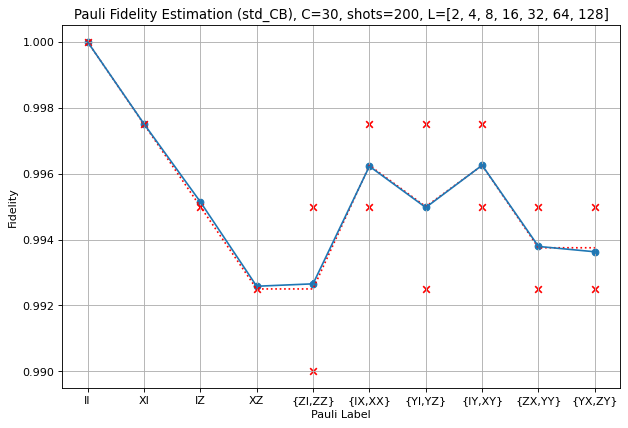

In [179]:


########### std_CB estimate
cb_fidelity_list = result['cb']['fidelity']
cb_stdev_list = result['cb']['stdev']

deg_list1 = ['II','XI','IZ','XZ','{ZI,ZZ}','{IX,XX}','{YI,YZ}','{IY,XY}','{ZX,YY}','{YX,ZY}']
cb_deg_fidelity = {} 
cb_deg_stdev = {}
cb_true = {}
for label in deg_list1:
    if len(label) == 2:
        cb_deg_fidelity[label] = cb_fidelity_list[label]
        cb_deg_stdev[label] = cb_stdev_list[label]
        cb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        cb_deg_fidelity[label] = (cb_fidelity_list[pp1]+cb_fidelity_list[pp2])/2
        cb_deg_stdev[label] = np.sqrt(cb_stdev_list[pp1]**2 + cb_stdev_list[pp2]**2)
        cb_true[label] = (f_true[pp1] + f_true[pp2])/2


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
plt.errorbar(deg_list1,[cb_deg_fidelity[x] for x in deg_list1],[cb_deg_stdev[x] for x in deg_list1])
# plt.scatter(deg_list1,[f_true[x] for x in deg_list1],,c='red',marker='x')
# plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
plt.plot(deg_list1,[cb_true[x] for x in deg_list1],ls=':',c='red')

for label in deg_list1:
    if len(label) == len('II'):
        plt.scatter(label,f_true[label],c='red',marker='x')
    else:
        plt.scatter(label,f_true[label[1:3]],c='red',marker='x')
        plt.scatter(label,f_true[label[4:6]],c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
plt.title("Pauli Fidelity Estimation (std_CB), C=%d, shots=%d, L=%s"%(C,shots,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")



Text(0, 0.5, 'Fidelity')

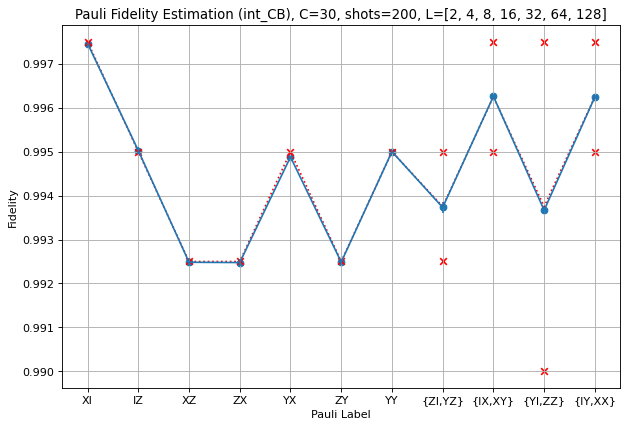

In [180]:
########### int_CB estimate
icb_fidelity_list = result['int_cb']['fidelity']
icb_stdev_list = result['int_cb']['stdev']

deg_list2 = ['XI','IZ','XZ','ZX','YX','ZY','YY','{ZI,YZ}','{IX,XY}','{YI,ZZ}','{IY,XX}']
icb_deg_fidelity = {} 
icb_deg_stdev = {}
icb_true = {}
for label in deg_list2:
    if len(label) == 2:
        icb_deg_fidelity[label] = icb_fidelity_list[label]
        icb_deg_stdev[label] = icb_stdev_list[label]
        icb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        icb_deg_fidelity[label] = (icb_fidelity_list[pp1]+icb_fidelity_list[pp2])/2
        icb_deg_stdev[label] = np.sqrt(icb_stdev_list[pp1]**2 + icb_stdev_list[pp2]**2)
        icb_true[label] = (f_true[pp1]+f_true[pp2])/2


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list2,[icb_deg_fidelity[x] for x in deg_list2])
plt.errorbar(deg_list2,[icb_deg_fidelity[x] for x in deg_list2],[icb_deg_stdev[x] for x in deg_list2])
# plt.scatter(deg_list1,[f_true[x] for x in deg_list1],,c='red',marker='x')
# plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
plt.plot(deg_list2,[icb_true[x] for x in deg_list2],ls=':',c='red')
for label in deg_list2:
    if len(label) == len('II'):
        plt.scatter(label,f_true[label],c='red',marker='x')
    else:
        plt.scatter(label,f_true[label[1:3]],c='red',marker='x')
        plt.scatter(label,f_true[label[4:6]],c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
#plt.title("Pauli Fidelity Estimation (int_CB), C=%d, shots=%d"%(C,shots) +", L=",+str(Lrange))
plt.title("Pauli Fidelity Estimation (int_CB), C=%d, shots=%d, L=%s"%(C,shots,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")


In [181]:
####### compare redundancy


In [182]:
####### use intercept information (Todo: Stdev analysis)
full_fidelity = {}
full_stdev = {}

full_fidelity['II'] = 1.0
full_stdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    full_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    full_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    full_fidelity[label] = icb_fidelity_list[label]
    full_stdev[label] = icb_stdev_list[label]

full_fidelity['ZI'] = result['intc_cb']['dec_fidelity']['ZI']
full_fidelity['ZZ'] = result['intc_cb']['dec_fidelity']['ZZ']
full_fidelity['XX'] = result['intc_cb']['dec_fidelity']['XX']
full_fidelity['IX'] = result['intc_cb']['dec_fidelity']['IX']
full_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']**2/full_fidelity['ZI']
full_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']**2/full_fidelity['ZZ']
full_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']**2/full_fidelity['XX']
full_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']**2/full_fidelity['IX']

full_stdev['ZI'] = result['intc_cb']['dec_stdev']['ZI']
full_stdev['ZZ'] = result['intc_cb']['dec_stdev']['ZZ']
full_stdev['XX'] = result['intc_cb']['dec_stdev']['XX']
full_stdev['IX'] = result['intc_cb']['dec_stdev']['IX']
full_stdev['YZ'] = np.sqrt(4 * icb_deg_fidelity['{ZI,YZ}']**2/full_fidelity['ZI']**2 * icb_deg_stdev['{ZI,YZ}']**2 + icb_deg_fidelity['{ZI,YZ}']**4/full_fidelity['ZI']**4 * full_stdev['ZI']**2)
full_stdev['YI'] = np.sqrt(4 * icb_deg_fidelity['{YI,ZZ}']**2/full_fidelity['ZZ']**2 * icb_deg_stdev['{YI,ZZ}']**2 + icb_deg_fidelity['{YI,ZZ}']**4/full_fidelity['ZZ']**4 * full_stdev['ZZ']**2)
full_stdev['IY'] = np.sqrt(4 * icb_deg_fidelity['{IY,XX}']**2/full_fidelity['XX']**2 * icb_deg_stdev['{IY,XX}']**2 + icb_deg_fidelity['{IY,XX}']**4/full_fidelity['XX']**4 * full_stdev['XX']**2)
full_stdev['XY'] = np.sqrt(4 * icb_deg_fidelity['{IX,XY}']**2/full_fidelity['IX']**2 * icb_deg_stdev['{IX,XY}']**2 + icb_deg_fidelity['{IX,XY}']**4/full_fidelity['IX']**4 * full_stdev['IX']**2)


Text(0, 0.5, 'Fidelity')

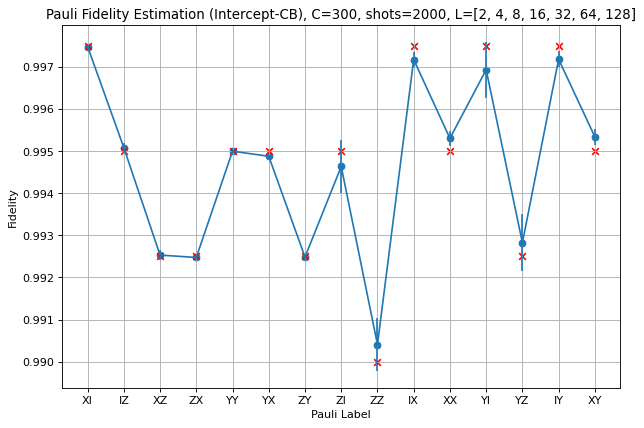

In [183]:
plt.figure(figsize=(9, 6), dpi=80)
n=2
#pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)]
pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']

plt.scatter(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list))
plt.errorbar(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list),yerr = list(full_stdev[x] for x in pauli_request_list))

plt.scatter(pauli_request_list,list(f_true[x] for x in pauli_request_list),c='red',marker='x')
#plt.plot(pauli_request_list,list(f_true[x] for x in pauli_request_list),ls=':',c='red',marker='x')

plt.grid(True)
plt.title("Pauli Fidelity Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")

Text(0, 0.5, 'Error rate')

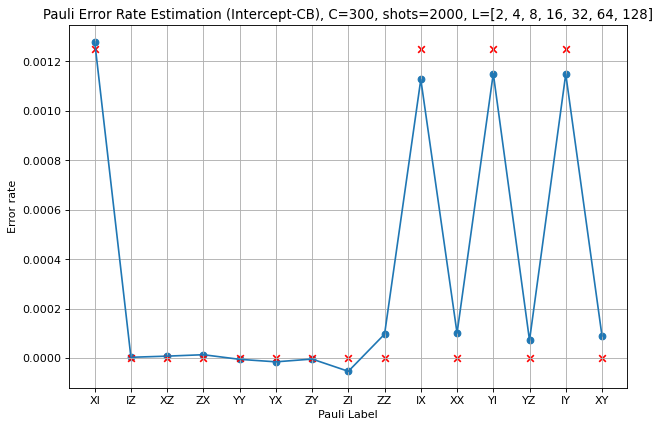

In [184]:
######### Pauli error rate calculation
######### Todo: add variance estimation
def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    
full_error = fidelity_to_error(full_fidelity,n)
true_error = fidelity_to_error(f_true,n)



# n=2
# f_true_fid = {}
# f_dec_fid = {}
# for key,value in f_true.items():
#     f_true_fid[key] = 1-value
# for key,value in f_dec.items():
#     f_dec_fid[key] = 1-value

# true_pauli_error = fidelity_to_error(f_true_fid,n)
# intercept_pauli_error = fidelity_to_error(f_dec_fid,n)
# # print(true_pauli_error)
# # print(intercept_pauli_error)


plt.figure(figsize=(9, 6), dpi=80)
plt.scatter(pauli_request_list,list(full_error[x] for x in pauli_request_list))

plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Error rate")



In [185]:
################## calculate distance
tvd = 0
for key in full_error:
    tvd += abs(full_error[key]-true_error[key])
tvd /= 2

print("TVD(p_CB,p_true) = %0.10f"%(tvd))

f_l1_all = 0
p_l1_all = 0
f_l1_all_std = 0
for key in full_error:
    p_l1_all += abs(full_error[key]-true_error[key])
    f_l1_all += abs(full_fidelity[key]-f_true[key])
    f_l1_all_std += full_stdev[key]**2
f_l1_all_std = np.sqrt(f_l1_all_std)

p_l1_learnable = 0
f_l1_learnable = 0
f_l1_learnable_std = 0
for key in ['XI','IZ','XZ','ZX','YY','YX','ZY']:
    p_l1_learnable += abs(full_error[key]-true_error[key])
    f_l1_learnable += abs(full_fidelity[key]-f_true[key])
    f_l1_learnable_std += full_stdev[key]**2
f_l1_learnable_std = np.sqrt(f_l1_learnable_std)

print([f_l1_all,f_l1_all_std,f_l1_learnable,f_l1_learnable_std])

print(p_l1_learnable)

TVD(p_CB,p_true) = 0.0004143803
[0.0032314696312942814, 0.0013776020700205357, 0.0002885404233561317, 0.0002061070623464025]
7.820886260593435e-05
